## 1. Outline 

1. Load the dataset and visualise
2. add batchnorm layers
3. Comparison with and without batch normalization layers
4. Add Dropout layer
5. Comparison with and without dropout layers

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import torchvision.models as models

from tqdm import tqdm_notebook

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device                

device(type='cuda', index=0)

## 2. Dataset and visualization

In [2]:
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform = transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform = transforms.ToTensor())
batch_size = 128
trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

0it [00:00, ?it/s]

100%|█████████▉| 170450944/170498071 [00:12<00:00, 16351466.62it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
classes = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

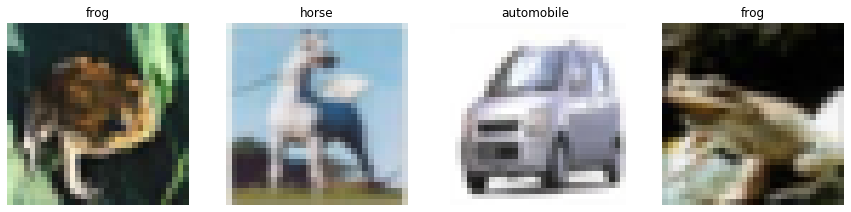

In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

def show_batch_images(dataloader, no_images=4):
  images,labels = iter(dataloader).next()
  plt.figure(figsize=(15,10))
  
  for i, (img,label) in enumerate(zip(images[0:no_images],labels[0:no_images])):
    img = np.transpose(img.numpy(), (1,2,0))
    ax = plt.subplot(1,no_images,i+1)
    ax.imshow(img, cmap='Greys_r')
    ax.set_title(classes[label.item()])
    ax.axis('off')
 
  plt.show()
  
show_batch_images(trainloader)

In [0]:
def return_accuracy(data_loader,model):
  correct = 0
  total = 0
  model.eval()
  for images,labels in data_loader:
    images,labels = images.to(device), labels.to(device)
    total += len(images)
    correct += torch.sum(torch.argmax(model(images),dim=1)==labels).item()
  return correct/total*100

## 3. Batch Normalization

In [0]:
class FCmodel(nn.Module):
  def __init__(self):
    super(FCmodel, self).__init__()
    self.classifier = nn.Sequential(
        nn.Linear(3072,48),
        nn.ReLU(),
        nn.Linear(48,24),
        nn.ReLU(),
        nn.Linear(24,10)
    )
    
  def forward(self,x):
    x = x.view(x.size(0),-1) # flattening the image
    x = self.classifier(x)
    return x
  
  
class FCmodel_BN(nn.Module):
  def __init__(self):
    super(FCmodel_BN, self).__init__()
    self.classifier = nn.Sequential(
        nn.Linear(3072,48),
        nn.BatchNorm1d(48),
        nn.ReLU(),
        nn.Linear(48,24),
        nn.BatchNorm1d(24),
        nn.ReLU(),
        nn.Linear(24,10)
    )
    
  def forward(self,x):
    x = x.view(x.size(0),-1) # flattening the image
    x = self.classifier(x)
    return x

In [7]:
model1 = FCmodel().to(device)
model2 = FCmodel_BN().to(device)

loss_fn = nn.CrossEntropyLoss()
opt1 = optim.Adam(model1.parameters(), lr=1e-2)
opt2 = optim.Adam(model2.parameters(), lr=1e-2)

print(model1)
print(model2)

FCmodel(
  (classifier): Sequential(
    (0): Linear(in_features=3072, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=10, bias=True)
  )
)
FCmodel_BN(
  (classifier): Sequential(
    (0): Linear(in_features=3072, out_features=48, bias=True)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=48, out_features=24, bias=True)
    (4): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=24, out_features=10, bias=True)
  )
)


**Note**: Batch normalization is continously computing the mean and standard deviation and find the right normalization for each feature at 2 layers in this case

find out how many batches are loaded at every epoch - enumerating every iteration over the dataloader 

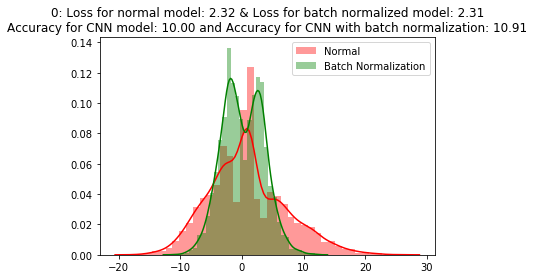

170500096it [00:29, 16351466.62it/s]                               

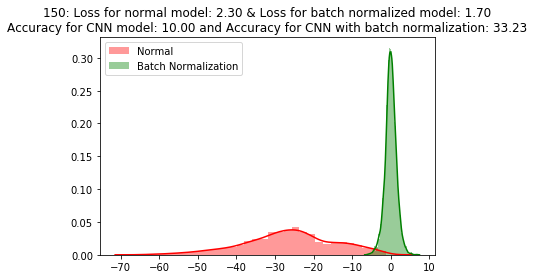

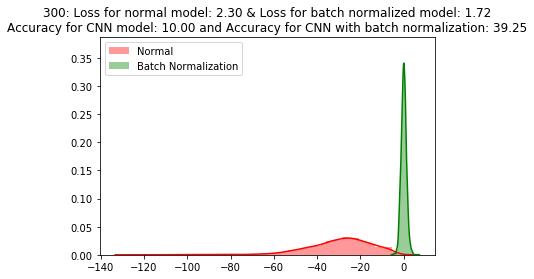

Exception ignored in: <bound method tqdm.__del__ of 170500096it [00:49, 16351466.62it/s]>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 931, in __del__
    self.close()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 1133, in close
    self._decr_instances(self)
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 496, in _decr_instances
    cls.monitor.exit()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py", line 52, in exit
    self.join()
  File "/usr/lib/python3.6/threading.py", line 1053, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread


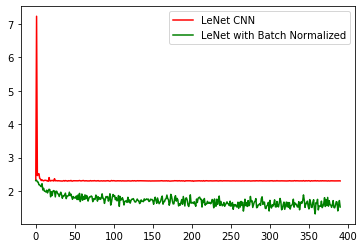

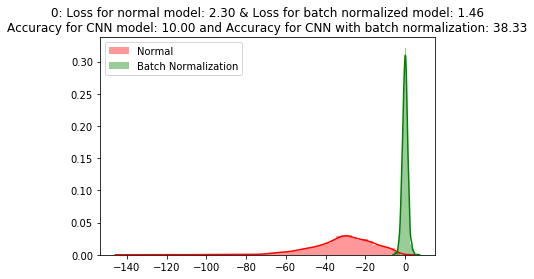

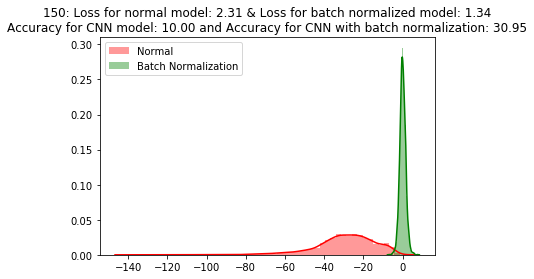

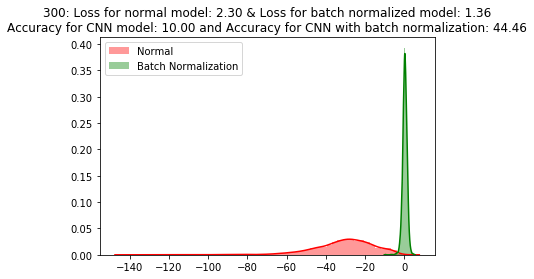

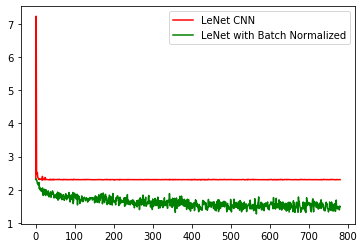

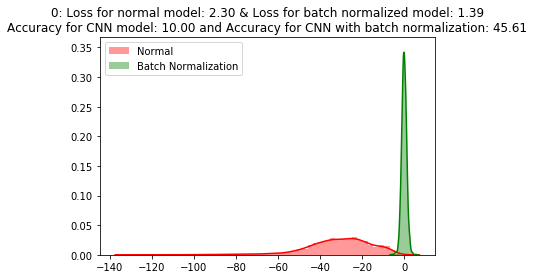

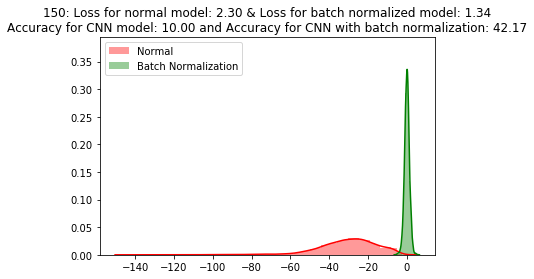

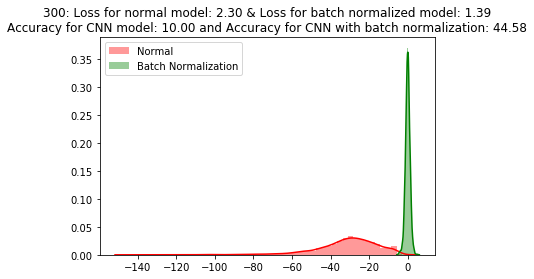

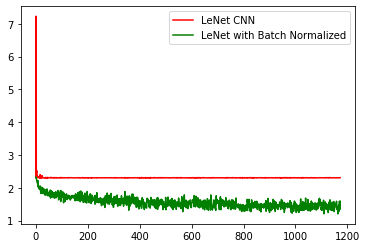

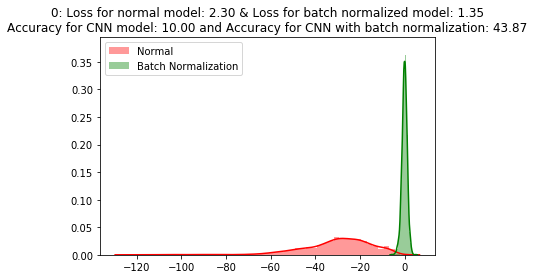

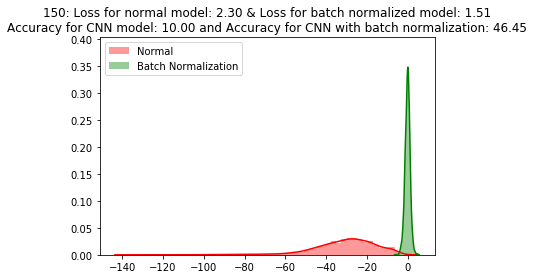

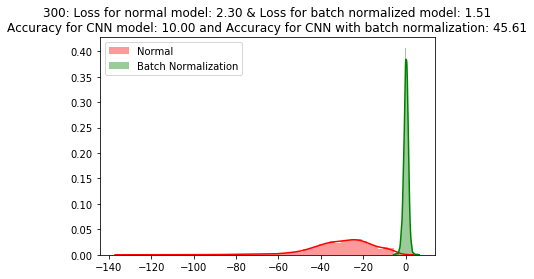

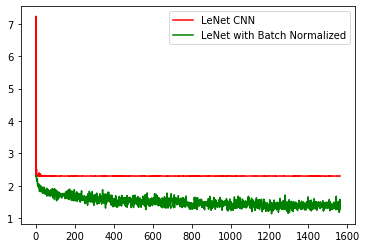

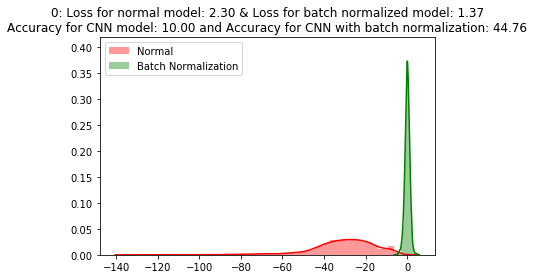

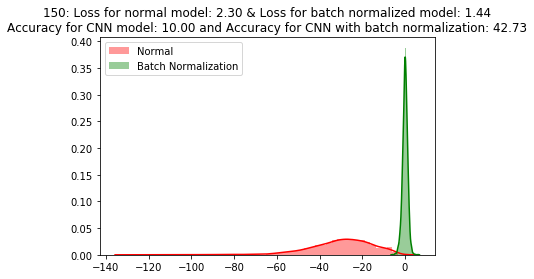

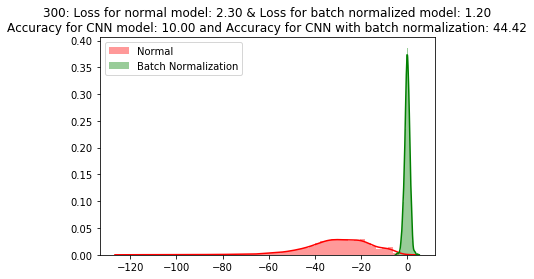

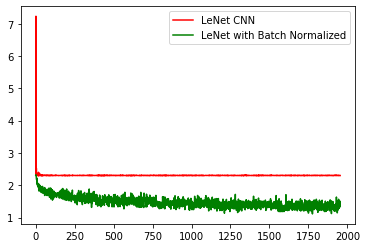

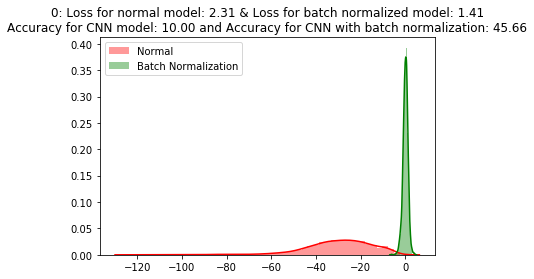

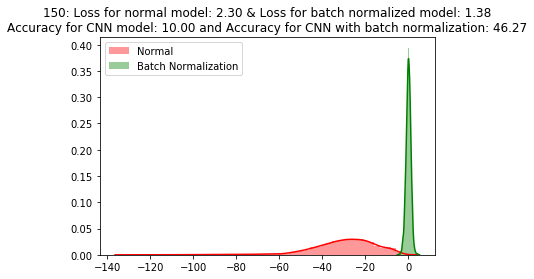

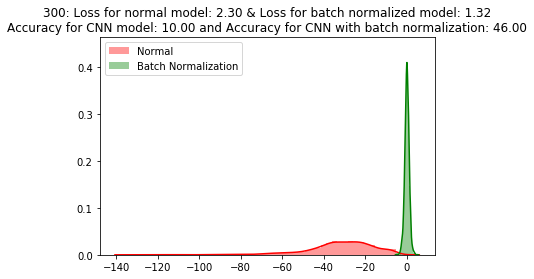

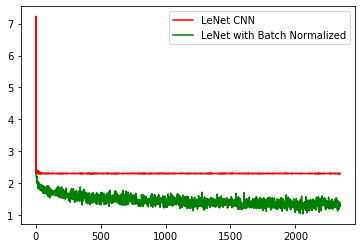

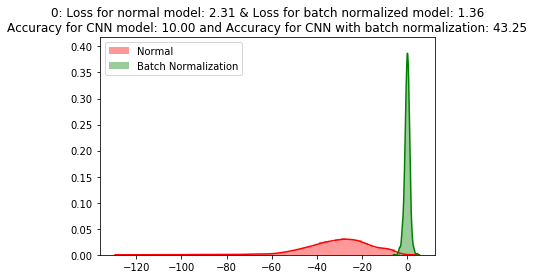

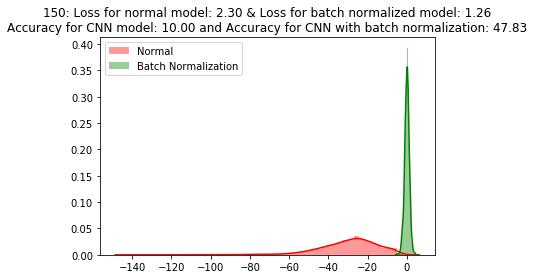

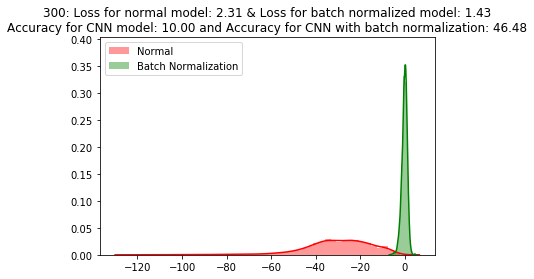

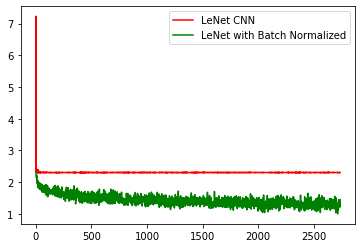

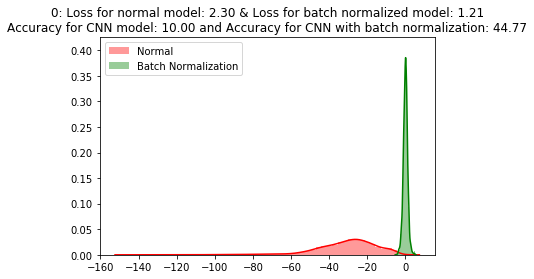

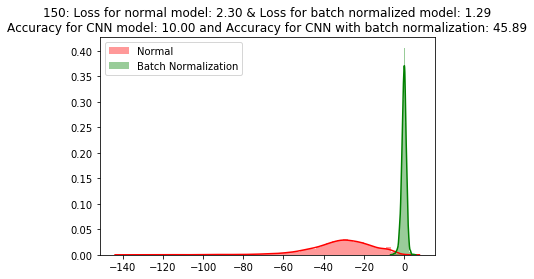

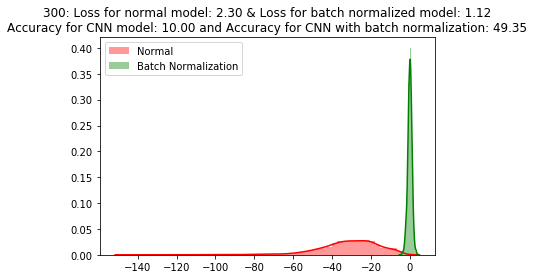

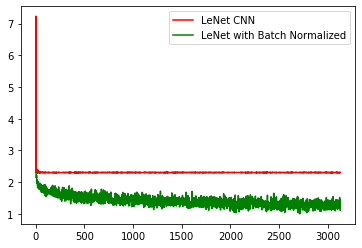

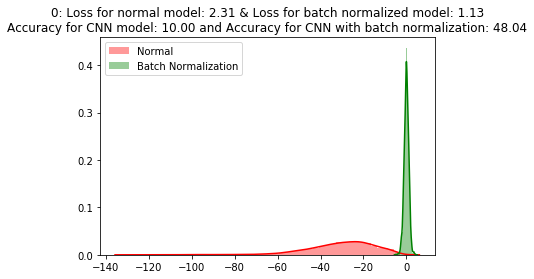

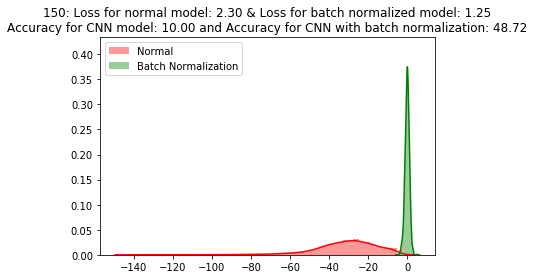

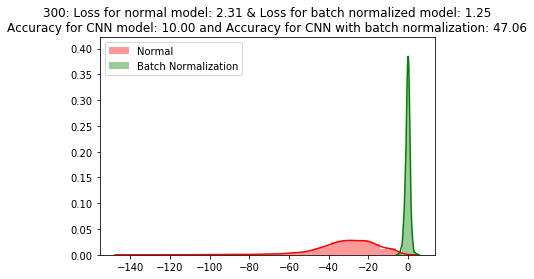

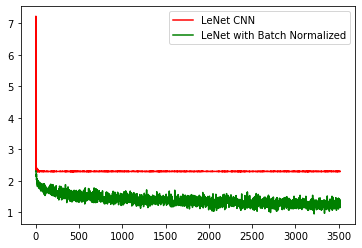

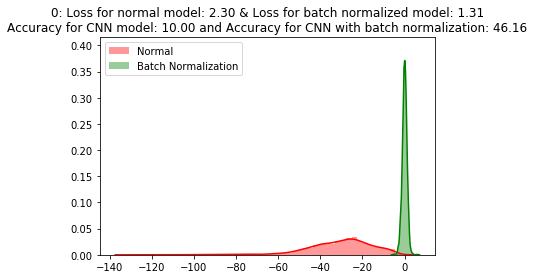

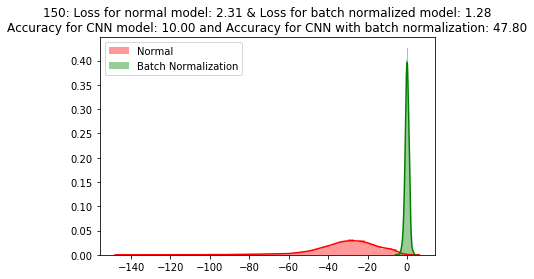

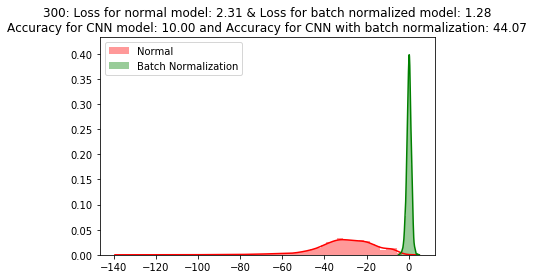

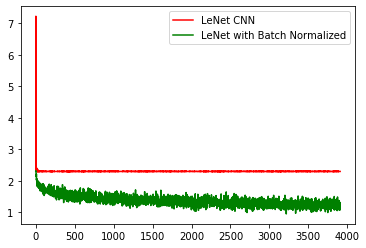

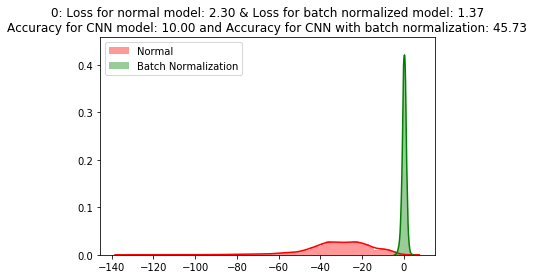

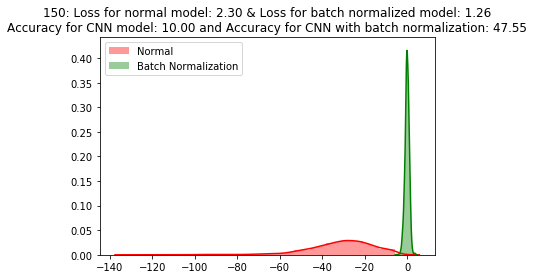

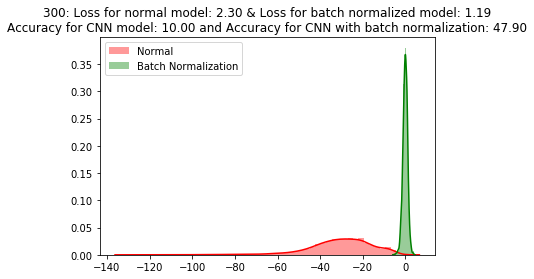

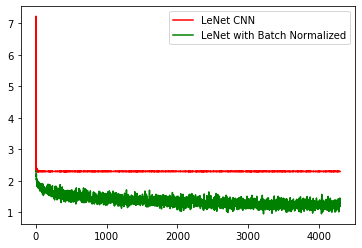

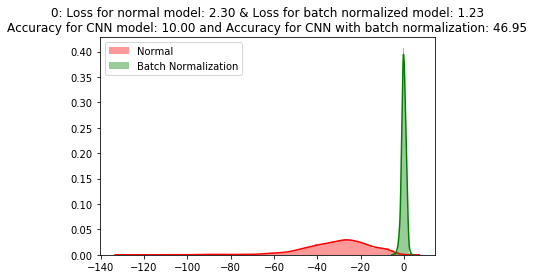

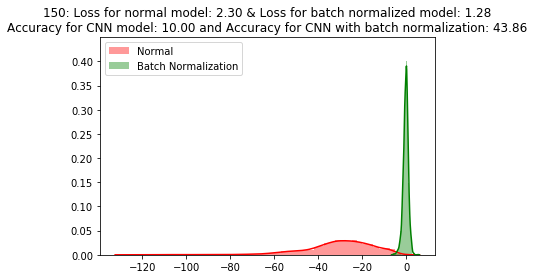

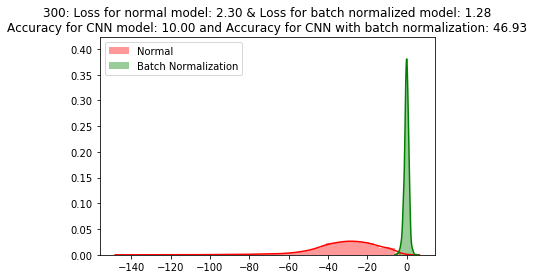

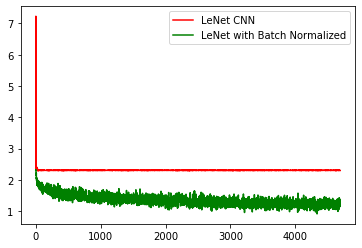

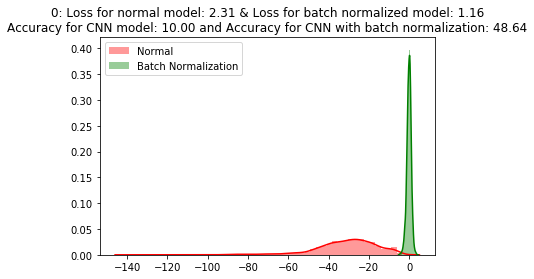

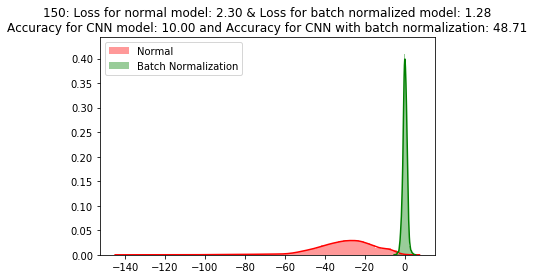

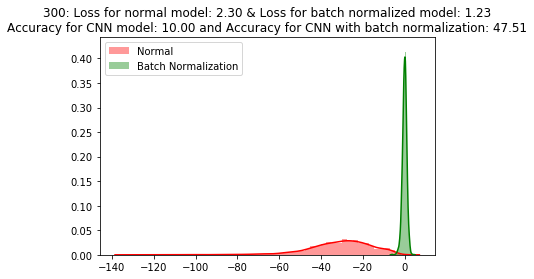

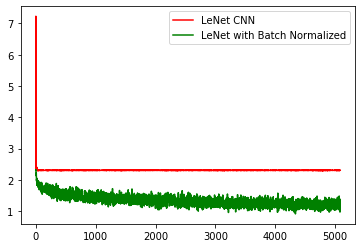

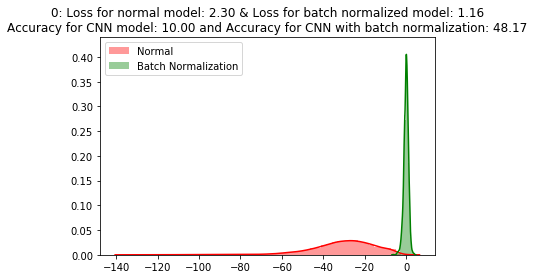

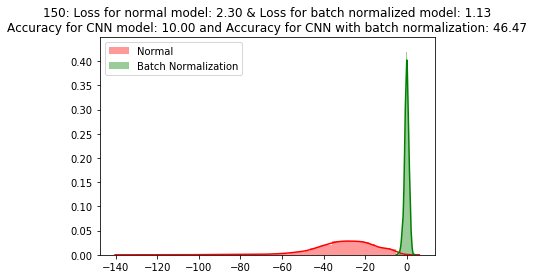

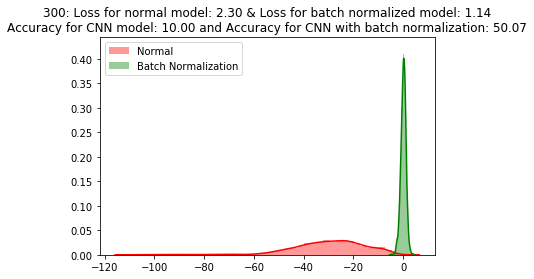

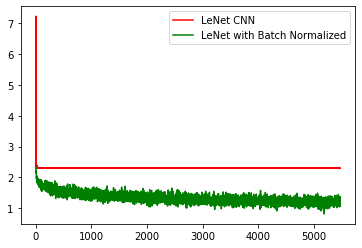

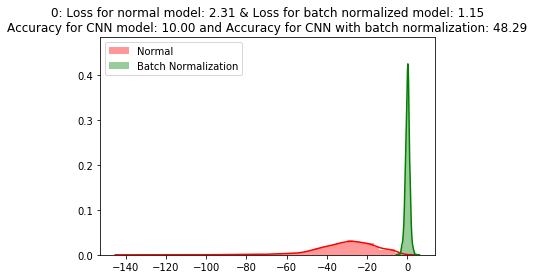

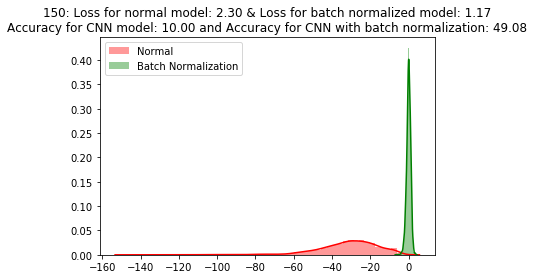

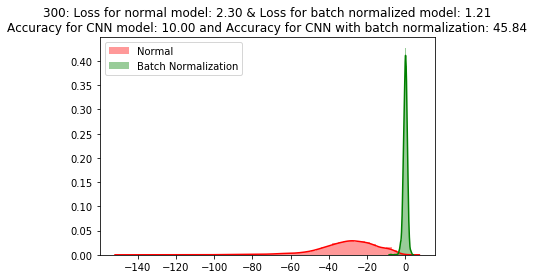

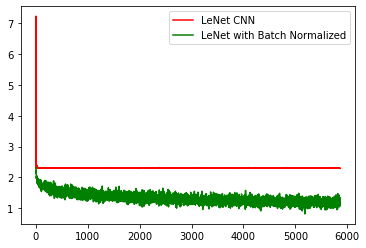

CPU times: user 5min 36s, sys: 2.77 s, total: 5min 39s
Wall time: 6min 4s


In [8]:
%%time 

max_epochs = 15

loss_arr = []
loss_arr_bn = []

for _ in range(max_epochs):
  
  for i, (images,labels) in tqdm_notebook(enumerate(trainloader),unit='batch ',total=len(dataset)//batch_size):
    images, labels = images.to(device), labels.to(device)
    # training the fully connected model
    opt1.zero_grad()
    outputs = model1(images)
    
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt1.step()
    
    # training the batch normalization model
    
    opt2.zero_grad()
    outputs_bn = model2(images)
    loss_bn = loss_fn(outputs_bn,labels)
    loss_bn.backward()
    opt2.step()
    
    loss_arr.append(loss.item())
    loss_arr_bn.append(loss_bn.item())
    
    if i % 150 == 0:
      inputs = images.view(images.size(0),-1)
      model1.eval()
      model2.eval()
      
      # visualizing the outputs of the hidden layer 
      a = model1.classifier[0](inputs)
      a = model1.classifier[1](a)
      a = model1.classifier[2](a)
      a = a.detach().cpu().numpy().ravel()
      sns.distplot(a, kde=True, color='r', label='Normal')
      acc_cnn = return_accuracy(testloader,model1)
      
      b = model2.classifier[0](inputs)
      b = model2.classifier[1](b)
      b = model2.classifier[2](b)
      b = model2.classifier[3](b)
      b = model2.classifier[4](b)
      b = b.detach().cpu().numpy().ravel()
      sns.distplot(b, kde=True, color='g', label='Batch Normalization')
      acc_cnn_bn = return_accuracy(testloader,model2)
      
      plt.title('%d: Loss for normal model: %.2f & Loss for batch normalized model: %.2f\nAccuracy for CNN model: %.2f and Accuracy for CNN with batch normalization: %.2f' % (i,loss.item(),loss_bn.item(),acc_cnn, acc_cnn_bn))
      plt.legend()
      model1.train()
      model2.train()
      plt.show()
      plt.pause(0.5)
      
  print('================================================')
  plt.plot(loss_arr,'r',label='LeNet CNN')
  plt.plot(loss_arr_bn,'g',label='LeNet with Batch Normalized')
  plt.legend()
  plt.show()

**Observation:**
1. The distribution of the 2nd layer is shrinking compared to the batch normalized 2nd layer which has a fairly well distribution. with batch normalization at every weight update the distribution remains fairly within a range whereas for the normal case without batch normalization, the distribution changes quite abruptly.
2.  Also the loss is decreasing more for the batch normalized case

## 4. 2D Batch Normalization

Similarly compare the results of 2d CNN model with batch normalization and without it.

In [0]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet,self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(3,6,5),
        nn.ReLU(),
        nn.AvgPool2d(2,2),
        nn.Conv2d(6,16,5,stride=1,padding=0),
        nn.ReLU(),
        nn.AvgPool2d(2,2)
    )
    
    self.fcc = nn.Sequential(
        nn.Linear(400,120),
        nn.ReLU(),
        nn.Linear(120,84),
        nn.ReLU(),
        nn.Linear(84,10)
    )
    
  def forward(self,x):
    x = self.conv(x)
    x = x.view(x.size(0),-1) # Flattening the image for feeding it to Fully connected neural network
    x = self.fcc(x)
    return x
  
class LeNet_BN(nn.Module):
  def __init__(self):
    super(LeNet_BN,self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(3,6,5),
        nn.BatchNorm2d(6),
        nn.LeakyReLU(),
        nn.AvgPool2d(2,2),
        nn.Conv2d(6,16,5,stride=1,padding=0),
        nn.BatchNorm2d(16),
        nn.LeakyReLU(),
        nn.AvgPool2d(2,2)
    )
    
    self.fcc = nn.Sequential(
        nn.Linear(400,120),
        nn.LeakyReLU(),
        nn.Linear(120,84),
        nn.LeakyReLU(),
        nn.Linear(84,10)
    )
    
  def forward(self,x):
    x = self.conv(x)
    x = x.view(x.size(0),-1) # Flattening the image for feeding it to Fully connected neural network
    x = self.fcc(x)
    return x
  
class LeNet_BN_DO(nn.Module):
  def __init__(self):
    super(LeNet_BN_DO,self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(3,6,5),
        nn.BatchNorm2d(6),
        nn.LeakyReLU(),
        nn.AvgPool2d(2,2),
        nn.Conv2d(6,16,5,stride=1,padding=0),
        nn.BatchNorm2d(16),
        nn.LeakyReLU(),
        nn.AvgPool2d(2,2)
    )
    
    self.fcc = nn.Sequential(
        nn.Linear(400,120),
        nn.Dropout(0.5),
        nn.LeakyReLU(),
        nn.Linear(120,84),
        nn.Dropout(0.5),
        nn.LeakyReLU(),
        nn.Linear(84,10)
    )
    
  def forward(self,x):
    x = self.conv(x)
    x = x.view(x.size(0),-1) # Flattening the image for feeding it to Fully connected neural network
    x = self.fcc(x)
    return x

In [10]:
model_CNN = LeNet().to(device)
print(model_CNN)

model_CNN_BN = LeNet_BN().to(device)
print(model_CNN_BN)

model_CNN_BN_DO = LeNet_BN_DO().to(device)
print(model_CNN_BN_DO)

loss_fn = nn.CrossEntropyLoss()
opt_cnn = optim.Adam(model_CNN.parameters(), lr=0.01)
opt_cnn_bn = optim.Adam(model_CNN_BN.parameters(), lr=0.01)
opt_cnn_bn_do = optim.Adam(model_CNN_BN_DO.parameters(), lr=0.01)

LeNet(
  (conv): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fcc): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)
LeNet_BN(
  (conv): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): 

### 4.1 Visualizing the ouptut of a particular hidden layer of each models and comparing them

Accuracy for LeNet model: 10.0  | Accuracy for LeNet with Batch Normalization: 10.0  | Accuracy for LeNet with Batch Normalization and Dropout: 10.0
Accuracy for LeNet model: 10.0  | Accuracy for LeNet with Batch Normalization: 44.75  | Accuracy for LeNet with Batch Normalization and Dropout: 30.599999999999998
Accuracy for LeNet model: 10.0  | Accuracy for LeNet with Batch Normalization: 49.32  | Accuracy for LeNet with Batch Normalization and Dropout: 37.81



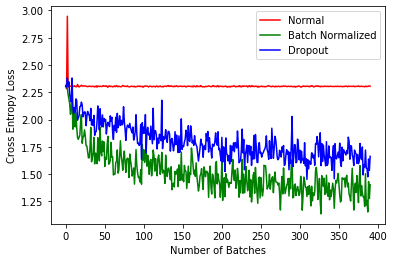

Accuracy for LeNet model: 10.0  | Accuracy for LeNet with Batch Normalization: 48.44  | Accuracy for LeNet with Batch Normalization and Dropout: 37.44
Accuracy for LeNet model: 10.0  | Accuracy for LeNet with Batch Normalization: 53.5  | Accuracy for LeNet with Batch Normalization and Dropout: 44.3
Accuracy for LeNet model: 10.0  | Accuracy for LeNet with Batch Normalization: 54.03  | Accuracy for LeNet with Batch Normalization and Dropout: 41.32



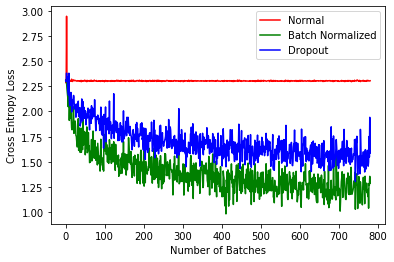

Accuracy for LeNet model: 10.0  | Accuracy for LeNet with Batch Normalization: 55.03  | Accuracy for LeNet with Batch Normalization and Dropout: 41.730000000000004
Accuracy for LeNet model: 10.0  | Accuracy for LeNet with Batch Normalization: 48.480000000000004  | Accuracy for LeNet with Batch Normalization and Dropout: 47.33
Accuracy for LeNet model: 10.0  | Accuracy for LeNet with Batch Normalization: 53.790000000000006  | Accuracy for LeNet with Batch Normalization and Dropout: 45.75



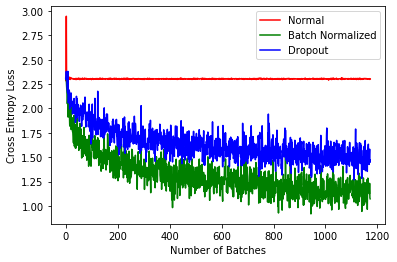

Accuracy for LeNet model: 10.0  | Accuracy for LeNet with Batch Normalization: 53.22  | Accuracy for LeNet with Batch Normalization and Dropout: 45.22
Accuracy for LeNet model: 10.0  | Accuracy for LeNet with Batch Normalization: 52.339999999999996  | Accuracy for LeNet with Batch Normalization and Dropout: 33.900000000000006
Accuracy for LeNet model: 10.0  | Accuracy for LeNet with Batch Normalization: 51.59  | Accuracy for LeNet with Batch Normalization and Dropout: 49.669999999999995



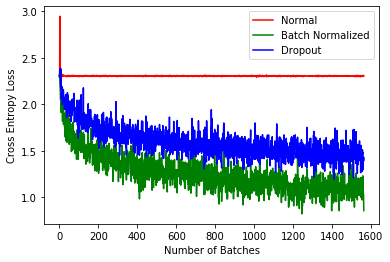

Accuracy for LeNet model: 10.0  | Accuracy for LeNet with Batch Normalization: 50.470000000000006  | Accuracy for LeNet with Batch Normalization and Dropout: 51.55
Accuracy for LeNet model: 10.0  | Accuracy for LeNet with Batch Normalization: 54.769999999999996  | Accuracy for LeNet with Batch Normalization and Dropout: 47.75
Accuracy for LeNet model: 10.0  | Accuracy for LeNet with Batch Normalization: 57.04  | Accuracy for LeNet with Batch Normalization and Dropout: 49.559999999999995



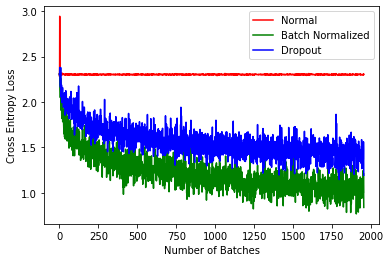

Accuracy for LeNet model: 10.0  | Accuracy for LeNet with Batch Normalization: 45.21  | Accuracy for LeNet with Batch Normalization and Dropout: 53.0
Accuracy for LeNet model: 10.0  | Accuracy for LeNet with Batch Normalization: 59.45  | Accuracy for LeNet with Batch Normalization and Dropout: 48.59
Accuracy for LeNet model: 10.0  | Accuracy for LeNet with Batch Normalization: 58.57  | Accuracy for LeNet with Batch Normalization and Dropout: 53.400000000000006



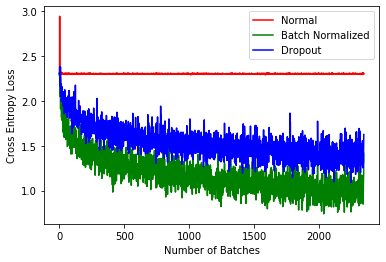

Accuracy for LeNet model: 10.0  | Accuracy for LeNet with Batch Normalization: 56.15  | Accuracy for LeNet with Batch Normalization and Dropout: 49.04
Accuracy for LeNet model: 10.0  | Accuracy for LeNet with Batch Normalization: 60.14000000000001  | Accuracy for LeNet with Batch Normalization and Dropout: 49.41
Accuracy for LeNet model: 10.0  | Accuracy for LeNet with Batch Normalization: 54.290000000000006  | Accuracy for LeNet with Batch Normalization and Dropout: 49.919999999999995



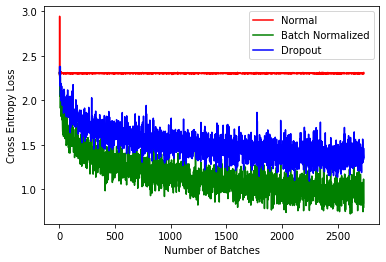

Accuracy for LeNet model: 10.0  | Accuracy for LeNet with Batch Normalization: 59.550000000000004  | Accuracy for LeNet with Batch Normalization and Dropout: 50.519999999999996
Accuracy for LeNet model: 10.0  | Accuracy for LeNet with Batch Normalization: 61.4  | Accuracy for LeNet with Batch Normalization and Dropout: 54.87
Accuracy for LeNet model: 10.0  | Accuracy for LeNet with Batch Normalization: 59.27  | Accuracy for LeNet with Batch Normalization and Dropout: 55.010000000000005



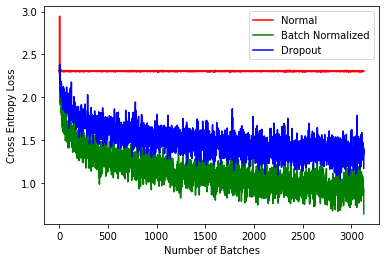

Accuracy for LeNet model: 10.0  | Accuracy for LeNet with Batch Normalization: 58.36  | Accuracy for LeNet with Batch Normalization and Dropout: 51.74999999999999
Accuracy for LeNet model: 10.0  | Accuracy for LeNet with Batch Normalization: 61.199999999999996  | Accuracy for LeNet with Batch Normalization and Dropout: 53.349999999999994
Accuracy for LeNet model: 10.0  | Accuracy for LeNet with Batch Normalization: 60.6  | Accuracy for LeNet with Batch Normalization and Dropout: 53.410000000000004



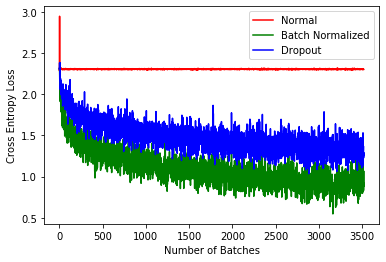

Accuracy for LeNet model: 10.0  | Accuracy for LeNet with Batch Normalization: 53.080000000000005  | Accuracy for LeNet with Batch Normalization and Dropout: 55.910000000000004
Accuracy for LeNet model: 10.0  | Accuracy for LeNet with Batch Normalization: 58.79  | Accuracy for LeNet with Batch Normalization and Dropout: 56.89999999999999
Accuracy for LeNet model: 10.0  | Accuracy for LeNet with Batch Normalization: 61.12  | Accuracy for LeNet with Batch Normalization and Dropout: 54.769999999999996



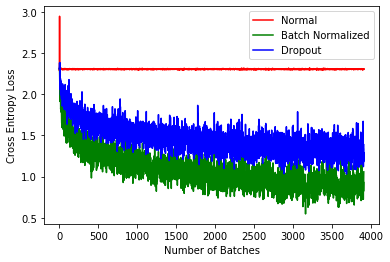

Accuracy for LeNet model: 10.0  | Accuracy for LeNet with Batch Normalization: 60.940000000000005  | Accuracy for LeNet with Batch Normalization and Dropout: 54.0
Accuracy for LeNet model: 10.0  | Accuracy for LeNet with Batch Normalization: 59.050000000000004  | Accuracy for LeNet with Batch Normalization and Dropout: 54.05
Accuracy for LeNet model: 10.0  | Accuracy for LeNet with Batch Normalization: 61.09  | Accuracy for LeNet with Batch Normalization and Dropout: 55.44



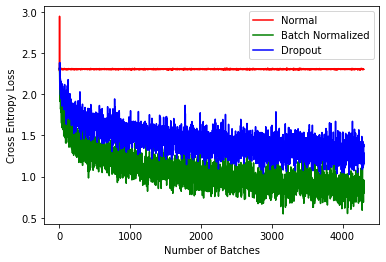

Accuracy for LeNet model: 10.0  | Accuracy for LeNet with Batch Normalization: 61.96  | Accuracy for LeNet with Batch Normalization and Dropout: 50.46000000000001
Accuracy for LeNet model: 10.0  | Accuracy for LeNet with Batch Normalization: 60.309999999999995  | Accuracy for LeNet with Batch Normalization and Dropout: 57.269999999999996
Accuracy for LeNet model: 10.0  | Accuracy for LeNet with Batch Normalization: 60.39  | Accuracy for LeNet with Batch Normalization and Dropout: 53.74



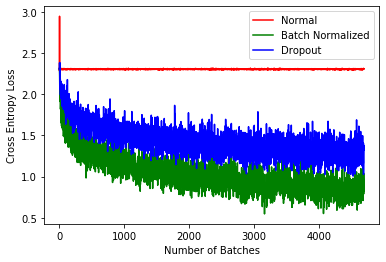

Accuracy for LeNet model: 10.0  | Accuracy for LeNet with Batch Normalization: 61.51  | Accuracy for LeNet with Batch Normalization and Dropout: 56.8
Accuracy for LeNet model: 10.0  | Accuracy for LeNet with Batch Normalization: 61.150000000000006  | Accuracy for LeNet with Batch Normalization and Dropout: 55.43
Accuracy for LeNet model: 10.0  | Accuracy for LeNet with Batch Normalization: 57.82000000000001  | Accuracy for LeNet with Batch Normalization and Dropout: 57.230000000000004



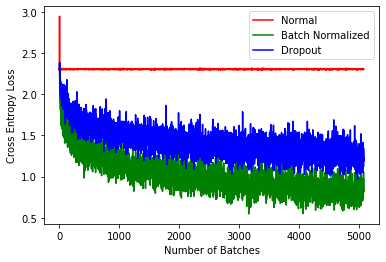

Accuracy for LeNet model: 10.0  | Accuracy for LeNet with Batch Normalization: 59.27  | Accuracy for LeNet with Batch Normalization and Dropout: 59.21999999999999
Accuracy for LeNet model: 10.0  | Accuracy for LeNet with Batch Normalization: 61.39  | Accuracy for LeNet with Batch Normalization and Dropout: 56.720000000000006
Accuracy for LeNet model: 10.0  | Accuracy for LeNet with Batch Normalization: 61.17  | Accuracy for LeNet with Batch Normalization and Dropout: 57.13



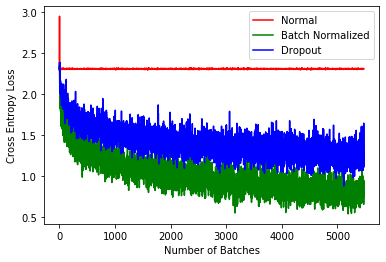

Accuracy for LeNet model: 10.0  | Accuracy for LeNet with Batch Normalization: 62.150000000000006  | Accuracy for LeNet with Batch Normalization and Dropout: 58.43000000000001
Accuracy for LeNet model: 10.0  | Accuracy for LeNet with Batch Normalization: 58.489999999999995  | Accuracy for LeNet with Batch Normalization and Dropout: 55.089999999999996
Accuracy for LeNet model: 10.0  | Accuracy for LeNet with Batch Normalization: 61.92999999999999  | Accuracy for LeNet with Batch Normalization and Dropout: 58.39



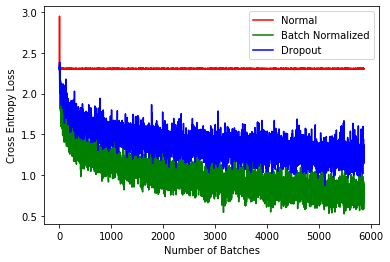

CPU times: user 7min 30s, sys: 3.37 s, total: 7min 34s
Wall time: 7min 37s


In [11]:
%%time 
max_epochs = 15

loss_arr = []
loss_arr_bn = []
loss_arr_bn_do = []

for _ in range(max_epochs):  
  for i, (images,labels) in tqdm_notebook(enumerate(trainloader),unit='batch ',total=len(dataset)//batch_size):      
    images, labels = images.to(device), labels.to(device)
    #train the normal lenet model
    pred = model_CNN(images)
    loss = loss_fn(pred,labels)
    loss_arr.append(loss.data.item())
    loss.backward()
    opt_cnn.step()
    opt_cnn.zero_grad()
    
    # train the lenet model with batch normalization
    pred_bn = model_CNN_BN(images)
    loss_bn = loss_fn(pred_bn,labels)
    loss_arr_bn.append(loss_bn.data.item())
    loss_bn.backward()
    opt_cnn_bn.step()
    opt_cnn_bn.zero_grad()
    
    # train the lenet model with batch normalization
    pred_bn_do = model_CNN_BN_DO(images)
    loss_bn_do = loss_fn(pred_bn_do,labels)
    loss_arr_bn_do.append(loss_bn_do.data.item())
    loss_bn_do.backward()
    opt_cnn_bn_do.step()
    opt_cnn_bn_do.zero_grad()
    
    # visualizing the output of the hidden layer
    if i % 150 == 0:
      # set the model to eval mode
      model_CNN.eval()
      model_CNN_BN.eval()
      model_CNN_BN_DO.eval()
    
      acc_cnn = return_accuracy(testloader, model_CNN)
      acc_cnn_bn = return_accuracy(testloader, model_CNN_BN)
      acc_cnn_bn_do = return_accuracy(testloader, model_CNN_BN_DO)
      print('Accuracy for LeNet model:',acc_cnn,' | Accuracy for LeNet with Batch Normalization:',acc_cnn_bn,' | Accuracy for LeNet with Batch Normalization and Dropout:',acc_cnn_bn_do)
      model_CNN.train()
      model_CNN_BN.train()
      model_CNN_BN_DO.train()
      
      
  print('================================================')
  plt.plot(loss_arr,'r',label='Normal')
  plt.plot(loss_arr_bn,'g',label='Batch Normalized')
  plt.plot(loss_arr_bn_do,'b',label='Dropout')
  plt.xlabel('Number of Batches')
  plt.ylabel('Cross Entropy Loss')
  plt.legend()
  plt.show()

More on improving the model:

https://stats.stackexchange.com/questions/272607/cifar-10-cant-get-above-60-accuracy-keras-with-tensorflow-backend




## 5. Training with ResNet model

In [0]:
model = torchvision.models.resnet50()
model = model.to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [13]:
import time, copy

def train_model(model, optimizer, criterion, num_epochs=10):
  since = time.time()
  
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch,num_epochs-1))
    print('-'*10)

    running_loss = 0.0
    running_correct = 0.0
    model.train()

    for images,labels in trainloader:

      images = images.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()

      with torch.set_grad_enabled(True):
        outputs = model(images)
        preds = torch.argmax(outputs,dim=1)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()

      # statistics
      running_loss += loss
      running_correct += torch.sum(preds==labels.data)

    epoch_loss = running_loss/len(trainloader)
    epoch_acc =  running_correct.double()/len(trainloader)

    print('Training Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    
    
    # Evaluation
    model.eval()
    running_test_loss = 0.0
    running_test_correct = 0.0
    for images,labels in testloader:
      images, labels = images.to(device), labels.to(device)

      with torch.set_grad_enabled(False):
        outputs = model(images)
        preds = torch.argmax(outputs,dim=1)
        loss = criterion(outputs,labels)
        
      running_test_loss += loss
      running_test_correct += torch.sum(preds==labels.data)
      
    epoch_test_loss = running_test_loss/len(testloader)
    epoch_test_acc =  running_test_correct.double()/len(testloader)

    print('Test Loss: {:.4f} Acc: {:.4f}'.format(epoch_test_loss, epoch_test_acc))

    if epoch_test_acc > best_acc:
      best_model_wts = copy.deepcopy(model.state_dict())
      best_acc = epoch_test_acc

  time_elapsed = time.time() - since
  print('Training complete in: {:.0f}m {:.0f}s'.format(time_elapsed/60, time_elapsed%60))
  print('Best accuracy: {:.2f}'.format(best_acc))
  
#   model.load_state_dict(best_model_wts)
  return model

trained_model = train_model(model, optimizer, criterion)

Epoch 0/9
----------
Training Loss: 1.8006 Acc: 48.1611
Test Loss: 1.4748 Acc: 59.9873
Epoch 1/9
----------
Training Loss: 1.4169 Acc: 64.7903
Test Loss: 2.6208 Acc: 38.3671
Epoch 2/9
----------
Training Loss: 1.3703 Acc: 67.0000
Test Loss: 1.4103 Acc: 63.2152
Epoch 3/9
----------
Training Loss: 1.3094 Acc: 70.2302
Test Loss: 1.1859 Acc: 75.8354
Epoch 4/9
----------
Training Loss: 1.1043 Acc: 79.6547
Test Loss: 2.2987 Acc: 62.3165
Epoch 5/9
----------
Training Loss: 1.1528 Acc: 77.7903
Test Loss: 2.7840 Acc: 49.2025
Epoch 6/9
----------
Training Loss: 1.3524 Acc: 68.3913
Test Loss: 2.1809 Acc: 39.8987
Epoch 7/9
----------
Training Loss: 1.5455 Acc: 61.0946
Test Loss: 1.5958 Acc: 68.4937
Epoch 8/9
----------
Training Loss: 1.1874 Acc: 75.4808
Test Loss: 1.1322 Acc: 76.1266
Epoch 9/9
----------
Training Loss: 0.9997 Acc: 83.6880
Test Loss: 1.2759 Acc: 75.6203
Training complete in: 7m 33s
Best accuracy: 76.13
